<a href="https://colab.research.google.com/github/AndreAmaduzzi/tensorflow-vs-pytorch/blob/main/pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch implementation of Object Detection Network

## Import Dependencies

In [1]:
!pip install xmltodict
from __future__ import print_function
from __future__ import division

import copy
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import matplotlib.pyplot as plt
import numpy as np
import random
import requests
import os
import time

from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
from timeit import default_timer as timer
from typing import Callable, Dict, List, Tuple, Union
from torchvision import datasets, models, transforms
from torchsummary import summary
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
import xml.etree.ElementTree as ET
import xmltodict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Runtime Settings

In [2]:
device = "cpu"
if torch.cuda.is_available:
  print('All good, a Gpu is available')
  device = torch.device("cuda:0")  
else:
  print('Please set GPU via Edit -> Notebook Settings.')

All good, a Gpu is available


## Reproducibility and Deterministic Mode

In [3]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(seed=7)

## Building Dataset
Dataset: [BCCD dataset](https://public.roboflow.com/object-detection/bccd)

3 classes (white blood cells, red blood cells, platelets)

364 images

In [4]:
! git clone https://github.com/Shenggan/BCCD_Dataset.git
%cd "BCCD_Dataset/"

fatal: destination path 'BCCD_Dataset' already exists and is not an empty directory.
/content/BCCD_Dataset


In [5]:
!ls

BCCD	      dataset	   export.py  LICENSE  README.md  test.csv
BCCD_Dataset  example.jpg  imagesBox  plot.py  scripts


In [6]:
# read list of training images
train_imgs = []
val_imgs  =  []
test_imgs =  []
root_imgs = "BCCD/ImageSets/Main/"
for split in ["train", "val", "test"]:
  imgs_path = os.path.join(root_imgs, f"{split}.txt")
  with open(imgs_path, "r") as f:
    for line in f:
      img = line.rstrip()
      print(img)


BloodImage_00001
BloodImage_00003
BloodImage_00004
BloodImage_00005
BloodImage_00006
BloodImage_00008
BloodImage_00009
BloodImage_00010
BloodImage_00012
BloodImage_00013
BloodImage_00020
BloodImage_00022
BloodImage_00023
BloodImage_00024
BloodImage_00026
BloodImage_00032
BloodImage_00034
BloodImage_00036
BloodImage_00038
BloodImage_00039
BloodImage_00040
BloodImage_00042
BloodImage_00043
BloodImage_00044
BloodImage_00045
BloodImage_00046
BloodImage_00047
BloodImage_00048
BloodImage_00049
BloodImage_00050
BloodImage_00052
BloodImage_00054
BloodImage_00056
BloodImage_00059
BloodImage_00069
BloodImage_00070
BloodImage_00071
BloodImage_00076
BloodImage_00078
BloodImage_00079
BloodImage_00081
BloodImage_00082
BloodImage_00083
BloodImage_00086
BloodImage_00087
BloodImage_00090
BloodImage_00091
BloodImage_00092
BloodImage_00094
BloodImage_00095
BloodImage_00097
BloodImage_00100
BloodImage_00101
BloodImage_00106
BloodImage_00107
BloodImage_00108
BloodImage_00110
BloodImage_00112
BloodImage_001

In [7]:
def parse_annotations_file(path_annotations):
  return 0

In [68]:
class BCCDDataset(Dataset):
    def __init__(
        self,
        split: str,
        path_images: str,
        ext_images: str,
        path_annotations: str,
        path_splits: str,
        transforms: torchvision.transforms = None,
    ) -> None:
        """Init the dataset

        Args:
            path_images: the path to the folder containing the images.
            ext_images: extension of the images.
            path_annotations: the path to the folder containing the annotations.
            path_splits: the path with the image names for each split
            transforms: the transformation to apply to the dataset.
        """
        imgs = []
        imgs_path = os.path.join(path_splits, f"{split}.txt")
        with open(imgs_path, "r") as f:
          for line in f:
            img = line.rstrip()
            imgs.append(img)

        self.images = sorted([os.path.join(path_images, img + f".{ext_images}") for img in imgs])  # path of each image
        print('imgs: ', self.images)
                
        self.transforms = transforms

        self.classes = ["__background__", "RBC", "WBC", "Platelets"]

        # build annotations
        path_annotations = sorted([os.path.join(path_annotations, img + ".xml") for img in imgs])
        print('path_ann: ', path_annotations)

        samples = []
        for path in path_annotations: # iterate over each xml => each image
          tree = ET.parse(path)
          root = tree.getroot()
          detections = []
          for child in root:
            sample = {}
            if child.tag == "object":
              detection = {}
              for grandchild in child: # iterate over attributes of the object
                if grandchild.tag=="name":
                  name = grandchild.text
                  detection["name"] = name
                  detection["label"] = self.classes.index(name)
                if grandchild.tag=="bndbox":
                  xmin = float(grandchild[0].text)
                  ymin = float(grandchild[1].text)
                  xmax = float(grandchild[2].text)
                  ymax = float(grandchild[3].text)
                  detection["bbox"] = (xmin, ymin, xmax, ymax)
              detections.append(detection)
          sample["img"] = path
          sample["detections"] = detections
          samples.append(sample)

        print('name: ', name)
        print('bounding box: ', xmin, ymin, xmax, ymax)

        self.annotations = samples
        print('how many annotations? ', len(self.annotations))

        print('annotations: ', self.annotations[0])

        if len(self.images) - len(self.annotations) != 0:
            raise AssertionError(
                f"Labels and Images differs in size: {len(self.images)} - {len(self.annotations)}."
            )

    def __getitem__(self, idx):
        path_image = self.images[idx]
        image = Image.open(path_image).convert("RGB")
      
        if self.transforms is not None:
            image = self.transforms(image)

        target = self.annotations[idx]["detections"]  # target is a list of dictionaries with keys "name", "label" and "bbox"

        return image, target

    def __len__(self):
        return len(self.images)

In [69]:
# Setting data loading parameters
bs = 28
n_workers = 2
img_transformations = transforms.ToTensor()   # transformations to apply to the input images

In [74]:
def draw_boxes(image: Image,
               targets: Dict,
               scores: List[float],
               colors: List[List[float]],
               normalized_coordinates: bool,
               add_text: bool = True) -> Image:
    """Draws a rectangle around each object together with the name of the category and the prediction score using a 
    different color for each category.

    Args:
        image: the input image.
        boxes: the bounding boxes in the format [x_min, y_min, x_max, y_max] 
               for all the objects in the image.
        classes: the name of the classes for all the objects in the image.
        labels: the labels for all the objects in the image.
        scores: the predicted scores for all the objects in the image..
        colors: the colors to use for each class of object.
        normalized_coordinates: if true the coordinates are multiplied 
                                according to the height and width of the image.
        add_text: if true add a box with the name of the category and 
                  the score.

    Returns:
        The generated image.
    """
    font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', 30)
    image_with_bb = copy.deepcopy(image)
    painter = ImageDraw.Draw(image_with_bb)

    boxes = []
    labels= []
    names = []
    for target in targets:
      boxes.append(target["bbox"])
      labels.append(target["label"])
      names.append(target["name"])

    for i, (box, label) in enumerate(zip(boxes, labels)):        
        color = tuple(colors[label].astype(np.int32))
        x_min, y_min, x_max, y_max = box
        
        if normalized_coordinates:
            width, height = image.size
            x_min *= width
            y_min *= height
            x_max *= width
            y_max *= height

        coord_bb = [(x_min, y_min), (x_max, y_max)]
        painter.rectangle(coord_bb, outline=color, width=4)
        
        if add_text:            
            label = labels[i]
            score = scores[i]
            name = names[i]
            text_in_box = f'{name}-{score:.2f}'
            text_bottom = y_max
            text_width, text_height = font.getsize(text_in_box)
            margin = np.ceil(0.05 * text_height)
            painter.rectangle([(x_min, text_bottom - text_height - 2 * margin), 
                               (x_min + text_width, text_bottom)], fill=color)
            
            painter.text((x_min + margin, text_bottom - text_height - margin), 
                         text_in_box, fill='black', font=font)

    return image_with_bb

In [75]:
def generate_colors(num_colors: int) -> np.array:
    """Generates an array with RGB triplets representing colors.

    Args:
        num_colors: the number of colors to generate.

    Returns: 
        the generated colors.
    """
    np.random.seed(0)
    colors = np.random.uniform(0, 255, size=(num_colors, 3))
    time_in_ms = 1000 * time.time()
    np.random.seed(int(time_in_ms) % 2 ** 32)

    return colors

In [76]:
colors_mi = generate_colors(4)

imgs:  ['BCCD/JPEGImages/BloodImage_00001.jpg', 'BCCD/JPEGImages/BloodImage_00003.jpg', 'BCCD/JPEGImages/BloodImage_00004.jpg', 'BCCD/JPEGImages/BloodImage_00005.jpg', 'BCCD/JPEGImages/BloodImage_00006.jpg', 'BCCD/JPEGImages/BloodImage_00008.jpg', 'BCCD/JPEGImages/BloodImage_00009.jpg', 'BCCD/JPEGImages/BloodImage_00010.jpg', 'BCCD/JPEGImages/BloodImage_00012.jpg', 'BCCD/JPEGImages/BloodImage_00013.jpg', 'BCCD/JPEGImages/BloodImage_00020.jpg', 'BCCD/JPEGImages/BloodImage_00022.jpg', 'BCCD/JPEGImages/BloodImage_00023.jpg', 'BCCD/JPEGImages/BloodImage_00024.jpg', 'BCCD/JPEGImages/BloodImage_00026.jpg', 'BCCD/JPEGImages/BloodImage_00032.jpg', 'BCCD/JPEGImages/BloodImage_00034.jpg', 'BCCD/JPEGImages/BloodImage_00036.jpg', 'BCCD/JPEGImages/BloodImage_00038.jpg', 'BCCD/JPEGImages/BloodImage_00039.jpg', 'BCCD/JPEGImages/BloodImage_00040.jpg', 'BCCD/JPEGImages/BloodImage_00042.jpg', 'BCCD/JPEGImages/BloodImage_00043.jpg', 'BCCD/JPEGImages/BloodImage_00044.jpg', 'BCCD/JPEGImages/BloodImage_0004

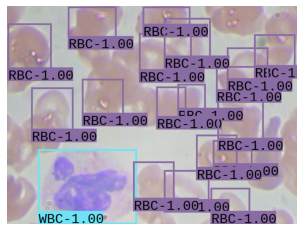

In [78]:
train_ds = BCCDDataset(path_images = "BCCD/JPEGImages",
                            split = "train",
                            ext_images = "jpg",
                            path_annotations = "BCCD/Annotations",
                            path_splits = "BCCD/ImageSets/Main",
                            transforms=img_transformations)

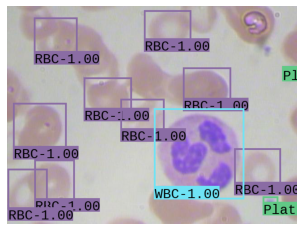

In [83]:
#@title Show BCCD Train Dataset { run: "auto", display-mode: "form" }
index_sample = 100  #@param {type:"slider", min:0, max:200, step:1}


image, targets = train_ds[index_sample]

image = transforms.ToPILImage()(image)

cell_with_bb = draw_boxes(image,
                          targets = targets,
                          scores=[1.0] * len(targets),
                          colors=colors_mi,
                          normalized_coordinates=False)
plt.imshow(cell_with_bb)
plt.axis("off")
plt.show()


In [ ]:
trainval_ds = OxfordIIITPet(root='./dataset/trainval/',
                         split='trainval',
                         download=True,
                         transform=img_transformations)



The function passed as [```collate_fn```](https://pytorch.org/docs/stable/data.html) argument is used to collate lists of samples into batches when they have different size. This function is the function that processes the batch you want to return from your `DataLoader`.

In [ ]:
def my_collate(batch):
    return tuple(batch)

In [ ]:
trainval_dl = DataLoader(dataset=trainval_ds,
                      batch_size=bs,
                      shuffle=True,
                      num_workers = n_workers,
                      collate_fn=my_collate
                      )

for i, data in enumerate(trainval_dl):
  print(data[0][0].shape)
  print(data[0][1])
  if i>1:
    break

torch.Size([3, 333, 500])
19
torch.Size([3, 300, 216])
2
torch.Size([3, 375, 500])
34
